# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

### Import
---

In [1]:
!pip uninstall open_earth_map -y


In [2]:
import os
import time
import warnings
import numpy as np
import torch
import torchvision
from pathlib import Path
import open_earth_map as oem

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Define main parameters

In [3]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/home/yinqiang/OEM-20231226T014733Z-001/OEM/OpenEarthMap_Mini_with_test_labels/OpenEarthMap_Mini"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 1.e-5
BATCH_SIZE = 8
NUM_EPOCHS = 1000
DEVICE = "cuda"
OUTPUT_DIR = "./oem/output_modified"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepare training and validation file lists.

In [4]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "images" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


### Prepare training and validation augmentations.

In [5]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Define training and validation dataloaders

In [6]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

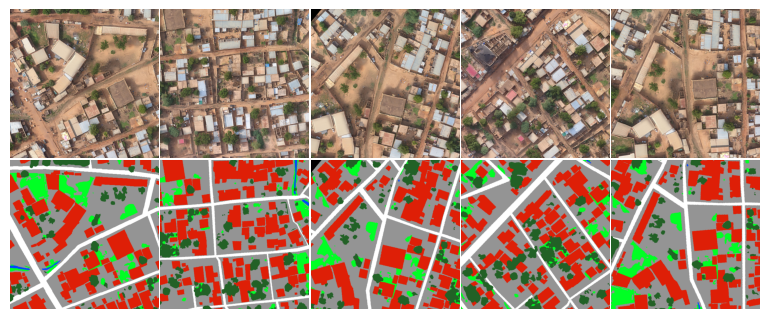

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [8]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Define the network architecture, optimizer, and criterion

In [9]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
# network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)
optimizer = torch.optim.Adam(network.parameters(), lr=LR,betas = (0.99, 0.999))
criterion = oem.losses.MCCLoss()

Loaded model:model.pth (Epoch=470, Score=0.690)


### Train and validate the network

In [ ]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    torch.cuda.empty_cache()

    torch.cuda.empty_cache()
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_multi_loss(
        model=network,
        optimizer=optimizer,
        
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_multi_loss(
        model=network,
      
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = train_logs["Score"]
    if train_logs["Score"]>max_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))

# Testing

### Prepare testing files

In [11]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


### Define test dataloader

In [12]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES)
test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=1,
    num_workers=10,
    shuffle=False,
)

### Load trained network

In [13]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)

Loaded model:model.pth (Epoch=994, Score=0.544)


In [14]:
test_logs = oem.runners.valid(
model=network,
criterion=criterion,
dataloader=test_data_loader,
device=DEVICE,
)

Valid:   0%|          | 0/313 [00:00<?, ?it/s]

Valid: 100%|██████████| 313/313 [00:26<00:00, 11.67it/s, Loss=0.633, Score=0.291]


In [15]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES)
test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=1,
    num_workers=10,
    shuffle=False,
)

### Visualize predictions

TypeError: list indices must be integers or slices, not str

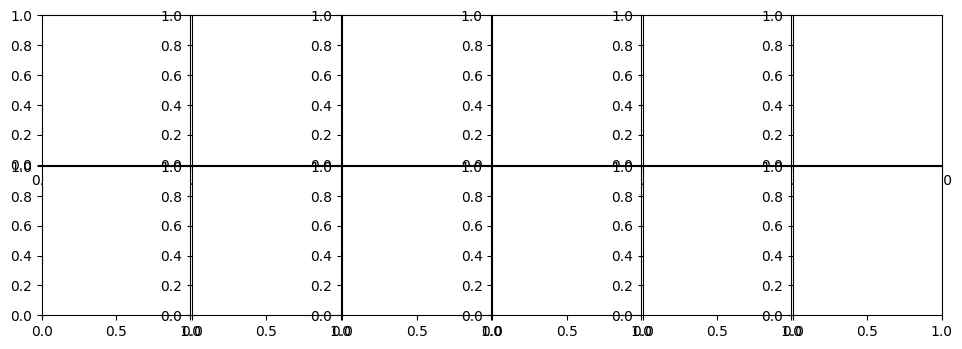

In [16]:
# visualize predictions
NPLOT = 6
idxs = test_fns[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    
    img = np.moveaxis(img.numpy(), 0, -1)
    label = np.argmax(prd.numpy(), axis=0)
    print(label.shape, np.unique(label))
    prd = oem.utils.make_rgb(label)

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

### Save predictions in png files

In [ ]:
import math
from PIL import Image

PR_DIR = "./save_data" # <= change path where you save predictions
os.makedirs(PR_DIR, exist_ok=True)

save_fns = []

network.eval().to(DEVICE)
for test_fn in test_fns:
    img = Image.fromarray(oem.dataset.load_multiband(test_fn))

    w, h = img.size[:2]
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
      img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
    img = np.array(img)

    # test time augmentation
    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[::-1, :, :].copy())
    imgs.append(img[::-1, ::-1, :].copy())

    input = torch.cat([torchvision.transforms.functional.to_tensor(x).unsqueeze(0) for x in imgs], dim=0).float().to(DEVICE)

    pred = []
    with torch.no_grad():
      msk = network(input)
      msk = torch.softmax(msk[:, :, ...], dim=1)
      msk = msk.cpu().numpy()
      pred = (msk[0, :, :, :] + msk[1, :, :, ::-1] + msk[2, :, ::-1, :] + msk[3, :, ::-1, ::-1])/4

    pred = Image.fromarray(pred.argmax(axis=0).astype("uint8"))
    y_pr = pred.resize((w, h), resample=Image.NEAREST)

    filename = os.path.basename(test_fn).replace('tif','png')
    save_fn = os.path.join(PR_DIR, filename)
    y_pr.save(save_fn)
    save_fns.append(save_fn)